In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import time
import string
import re

sc

In [3]:
text = sc.textFile('Jungle_Book.txt')

In [4]:
def splitlines(text):
    return text.split(' ')

splitted = text.flatMap(splitlines).collect()

In [36]:
start = time.time()

def get_freq(word):
    return word, 1

def get_count(a, b): # this will be used with reduceByKey
    return a+b

def switch_tuple(t): # this is needed to sort by Key (flips the passed tuple)
    return t[1], t[0]

freqs = text.flatMap(splitlines).map(get_freq).reduceByKey(get_count).map(switch_tuple).sortByKey(0, 1)

time_spark = time.time()-start

In [17]:
freqs.count() #total number of unique words in the text

9608

In [9]:
start = time.time()

freqs_2 = {}
for word in splitted:
    try:
        freqs_2[word] += 1
    except KeyError:
        freqs_2[word] = 1

time_py = time.time()-start

In [10]:
print 'Time Spark: ' + str(time_spark)
print 'Time Python: ' + str(time_py)

Time Spark: 1.08051204681
Time Python: 0.0592720508575


In [18]:
freqs_20 = freqs.collect()[:20]
print freqs_20

[(3573, u''), (3337, u'the'), (2166, u'and'), (1287, u'of'), (1214, u'to'), (1092, u'a'), (830, u'he'), (700, u'in'), (633, u'his'), (569, u'that'), (504, u'was'), (470, u'I'), (432, u'is'), (423, u'for'), (412, u'with'), (398, u'as'), (363, u'said'), (325, u'on'), (287, u'not'), (284, u'all')]


In [19]:
words = []
frequencies = []
for t in freqs_20:
    words.append(t[1])
    frequencies.append(t[0])

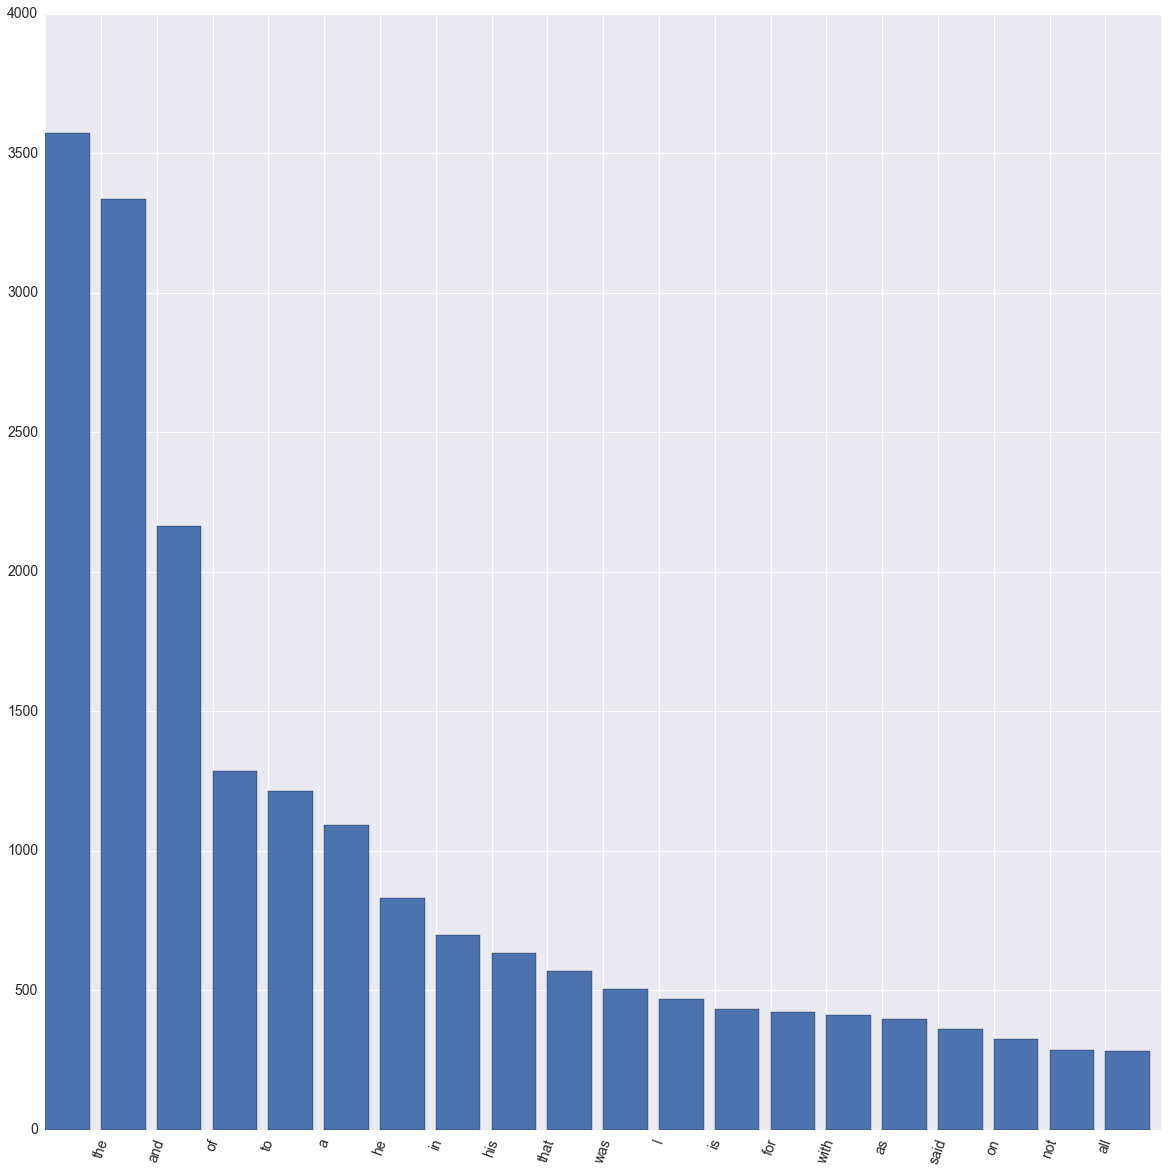

In [20]:
fig, ax = plt.subplots(figsize=(20,20))
plt.bar(range(0, len(frequencies)), frequencies, axes=ax)
plt.xticks(range(0, len(frequencies)), words, rotation=70, fontsize=14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14) 

In [22]:
freqs.filter(lambda pair: pair[1].startswith('time')).take(10) # this shows that we have to parse the text

[(69, u'time'),
 (15, u'time,'),
 (9, u'times'),
 (6, u'time.'),
 (5, u'time,"'),
 (1, u'time?"'),
 (1, u'time--"what'),
 (1, u'times.'),
 (1, u'time."'),
 (1, u'time;')]

## Exercise

* `The` and `the` currently have separated counts, fix this.
* Remove conjunctions like `a`, `o` and so on.
* Clear text from punctuation marks. 

In [78]:
wre = re.compile('\w')
print wre.sub('', 'This. Is, 22 A Text{}')
notwre = re.compile('[^\w]')
print notwre.sub('', 'This. Is, 22 A Text{}')
notwre = re.compile('([^\w\s]|\d+)')
print notwre.sub('', 'This. Is, 22 A Text{}').lower()

. ,   {}
ThisIs22AText
this is  a text


In [91]:
text.map(lambda line: line.replace('--', ' ').lower()) \
    .flatMap(lambda line: line.split()) \
    .map(lambda word: notwre.sub('', word)) \
    .filter(lambda word: len(word) > 2) \
    .map(lambda word: (word, 1)) \
    .reduceByKey(lambda v1, v2: v1+v2) \
    .sortBy(lambda pair: pair[1], False) \
    .take(20)
    
# to parse the text for 'stopwords' it is possible to use the list found at: http://www.ranks.nl/stopwords

[(u'the', 3637),
 (u'and', 2315),
 (u'that', 659),
 (u'his', 648),
 (u'was', 520),
 (u'for', 465),
 (u'said', 430),
 (u'with', 422),
 (u'they', 376),
 (u'him', 367),
 (u'all', 347),
 (u'but', 337),
 (u'you', 329),
 (u'not', 304),
 (u'had', 284),
 (u'have', 235),
 (u'little', 231),
 (u'when', 212),
 (u'out', 207),
 (u'mowgli', 205)]

# New exercice: Baby names
# ======================

[dataset found here](http://www.healthdata.gov/dataset/baby-names-beginning-2007/)

to launch mongodb server: `./bin/mongod --dbpath=./data`


In [95]:
import pymongo
import csv
cli = pymongo.MongoClient('mongodb://localhost:27017')

with open('/Users/adrianopagano/Desktop/Big_Dive/BigDive5/Data/Baby_Names__Beginning_2007.csv') as csvfile:
    babies = csv.reader(csvfile)
    next(babies)
    for row in babies:
        cli.testdb.babies.insert({'year': row[0],
                                  'firstname': row[1], 
                                  'county': row[2], 
                                  'sex': row[3], 
                                  'count': row[4]})

/Users/adrianopagano/Desktop/Big_Dive/BigDive5/DataScience/PythonDataScience/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: insert is deprecated. Use insert_one or insert_many instead.


In [96]:
cli.testdb.babies.count()

52252

In [97]:
babies_rdd = sc.mongoRDD('mongodb://localhost:27017/testdb.babies') # this creates a Spark RDD from the mongoDB collections

In [99]:
babies_rdd.take(2)

[{u'_id': ObjectId('5763c6a69d1fa22a55dbb9c3'),
  u'count': u'9',
  u'county': u'ST LAWRENCE',
  u'firstname': u'GAVIN',
  u'sex': u'M',
  u'year': u'2013'},
 {u'_id': ObjectId('5763c6a79d1fa22a55dbb9c4'),
  u'count': u'9',
  u'county': u'ST LAWRENCE',
  u'firstname': u'LEVI',
  u'sex': u'M',
  u'year': u'2013'}]

In [104]:
babies_rdd.filter(lambda d: d['firstname']=='MICHAEL').take(5)

[{u'_id': ObjectId('5763c6a79d1fa22a55dbb9e3'),
  u'count': u'68',
  u'county': u'NEW YORK',
  u'firstname': u'MICHAEL',
  u'sex': u'M',
  u'year': u'2013'},
 {u'_id': ObjectId('5763c6a79d1fa22a55dbbb01'),
  u'count': u'142',
  u'county': u'SUFFOLK',
  u'firstname': u'MICHAEL',
  u'sex': u'M',
  u'year': u'2013'},
 {u'_id': ObjectId('5763c6a79d1fa22a55dbbb92'),
  u'count': u'146',
  u'county': u'KINGS',
  u'firstname': u'MICHAEL',
  u'sex': u'M',
  u'year': u'2013'},
 {u'_id': ObjectId('5763c6a79d1fa22a55dbbc92'),
  u'count': u'66',
  u'county': u'WESTCHESTER',
  u'firstname': u'MICHAEL',
  u'sex': u'M',
  u'year': u'2013'},
 {u'_id': ObjectId('5763c6a89d1fa22a55dbbdbc'),
  u'count': u'106',
  u'county': u'NASSAU',
  u'firstname': u'MICHAEL',
  u'sex': u'M',
  u'year': u'2013'}]

In [ ]:
babies

In [101]:
names_to_counties = babies_rdd.map(lambda d: (d['firstname'], d['county']))
names_to_counties.take(5)

[(u'GAVIN', u'ST LAWRENCE'),
 (u'LEVI', u'ST LAWRENCE'),
 (u'LOGAN', u'NEW YORK'),
 (u'HUDSON', u'NEW YORK'),
 (u'GABRIEL', u'NEW YORK')]

In [102]:
grouped_names=names_to_counties.groupByKey()
grouped_names.take(5)

[(u'JOHNNY', <pyspark.resultiterable.ResultIterable at 0x10cf2c110>),
 (u'KELLEN', <pyspark.resultiterable.ResultIterable at 0x10cf2c190>),
 (u'NAYA', <pyspark.resultiterable.ResultIterable at 0x10cf2c150>),
 (u'ERIN', <pyspark.resultiterable.ResultIterable at 0x10cf2c550>),
 (u'DONOVAN', <pyspark.resultiterable.ResultIterable at 0x10cf2c090>)]

In [105]:
grouped_names.map(lambda pair: (pair[0], len(pair[1]))).sortBy(lambda pair: pair[1], False).take(10) # pair[1] is a list of all counties where the name appeared

[(u'EMMA', 322),
 (u'JACOB', 316),
 (u'LOGAN', 307),
 (u'OLIVIA', 303),
 (u'ISABELLA', 291),
 (u'SOPHIA', 283),
 (u'MASON', 282),
 (u'NOAH', 279),
 (u'AVA', 267),
 (u'ETHAN', 267)]

In [112]:
names_freqs = babies_rdd.map(lambda d: (d['firstname'], int(d['count']))).reduceByKey(lambda x,y: x+y)
names_freqs.sortBy(lambda pair: pair[1], False).take(10)

[(u'MICHAEL', 11565),
 (u'ISABELLA', 10207),
 (u'JACOB', 10008),
 (u'MATTHEW', 10003),
 (u'SOPHIA', 9874),
 (u'JAYDEN', 9869),
 (u'JOSEPH', 9762),
 (u'DANIEL', 9336),
 (u'ETHAN', 9274),
 (u'ANTHONY', 9235)]

In [118]:
babies_rdd.map(lambda d: (int(d['year']), int(d['count']))).reduceByKey(lambda x,y: x+y).sortBy(lambda pair: pair[1], False).sortBy(lambda pair: pair[0], True).collect()

[(2007, 120119),
 (2008, 120472),
 (2009, 118580),
 (2010, 116458),
 (2011, 115277),
 (2012, 114036),
 (2013, 112109),
 (2014, 126377)]

## Exercise

* Get most frequent name for each county

In [140]:
babies_rdd.map(lambda d: ((d['county'].lower(), d['firstname'].lower()), int(d['count']))) \
        .reduceByKey(lambda x,y: x+y) \
        .map(lambda pair: (pair[0][0], (pair[1], pair[0][1]))) \
        .reduceByKey(lambda freq1, freq2: max(freq1, freq2)).take(5)

[(u'seneca', (17, u'emma')),
 (u'madison', (50, u'jacob')),
 (u'delaware', (11, u'william')),
 (u'clinton', (46, u'ethan')),
 (u'ulster', (106, u'michael'))]